# Hull Tactical Market Prediction

### Import Libralies

In [184]:
# Utilities
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization
from colorama import Fore, Style
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# Models
import lightgbm as lgb

# Submission
import polars as pl
import kaggle_evaluation.default_inference_server

In [185]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [186]:
INNER_VAL_LEN = 180
TRADING_DAYS_PER_YR = 252

### Definition

In [187]:
# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal 
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal 
SIGNAL_MULTIPLIER: float = 7.5                 # Multiplier of the OLS market forward excess returns predictions to signal 

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float 
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters,
    signal_multiplier=None
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    
    # 予測値を基準に，投資戦略シグナルに変換
    # ret * signal_multiplier + 1 を min_signal ~ max_signal の範囲にクリップ
    if signal_multiplier is None:
        multi = params.signal_multiplier    
    else:
        multi = signal_multiplier
    
    ret = np.clip(
        ret_arr * multi + 1,
        params.min_signal, 
        params.max_signal
    )

    if ret.size < 20:
        print(f"Strategy:")
        for i, value in enumerate(ret): print(f'  {i}: {value:.4f}')

    return ret

In [188]:
# convert_ret_to_signalの動作確認
# 20個の乱数(0~1)
hoge = convert_ret_to_signal(np.array([5, 0.1, 0.3, -0.2, 1.3]), ret_signal_params)

Strategy:
  0: 2.0000
  1: 1.7500
  2: 2.0000
  3: 0.0000
  4: 2.0000


In [189]:
# ============ LOAD DATA ============
# プラットフォームがkaggleかローカルかで分岐
if os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None:
    # Kaggle上
    DATA_PATH: Path = Path('/kaggle/input/hull-tactical-market-prediction/')
else:
    BASE_PATH = Path.cwd()
    DATA_PATH: Path = BASE_PATH / 'data'


train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")

### Scoreing

In [190]:
class ParticipantVisibleError(Exception):
    # Custom error to show messages to participants
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, intermediate_res:list = []) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """
    solution = solution.copy().reset_index(drop=True)
    submission = submission.copy().reset_index(drop=True)
    solution['position'] = submission['prediction']

    # ありえない値を除外する (0 <= position <= 2)
        # 0 means that we don't invest in S & P at all but get only the risk-free rate.
        # 1 means that we invest all our money in S & P.
        # 2 means that we invest twice our capital in S & P while taking a credit at the risk-free rate.
        # -> つまり，普通に預金するか，S&Pに投資するか，S&Pに2倍レバレッジで投資するか（借金）の割合
    if solution['position'].max() > MAX_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_SIGNAL}')
    if solution['position'].min() < MIN_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_SIGNAL}')

    # Calculate strategy returns
    # フェデラルファンド金利(利息) * (1-予測値) + 予測値 * S&P500の翌日のリターン = 戦略のリターン(割合)
    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    # リターンとその標準偏差を用いてシャープレシオ（リスクあたりの効率）を計算
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate'] # 超過リターン -> 今回の戦略で得た割合から，リスクフリー時の割合を引いた分
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod() # 累積超過リターン -> 全期間の超過リターンをかけ合わせた分(1+で倍率に変換)
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1 # 平均超過リターン -> 複利は幾何平均で求める． また，倍率から割合に戻してる
    strategy_std = solution['strategy_returns'].std() # リターンの標準偏差

    trading_days_per_yr = 252 # 1年あたりの取引日数(固定値)
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr) # 年率換算したシャープレシオ. sqrt(252)をかけることで年率換算している（統計的な性質らしい）
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)  # 年率換算したボラティリティ(価格変動率)

    # Calculate market return and volatility
    # S&P500に投資し続けた場合のリターンとボラティリティを計算
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate'] # S&P500が利息を上回る割合
    market_excess_cumulative = (1 + market_excess_returns).prod() # ↑の累積
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1 # train: 0.0003066067595838273 幾何平均，割合化
    market_std = solution['forward_returns'].std() # S&P500のリターンの標準偏差
    
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100) # train: 16.748459963166347 %
    
    # Calculate the volatility penalty
    # ボラティリティペナルティを計算
    # -> 市場のボラティリティの1.2倍を超える場合のペナルティ
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    # リターンペナルティを計算
    # -> 市場のリターンを下回る場合のペナルティ
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    # ペナルティ値の反映
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    # print("strategy_excess_returns NaN数:", solution['strategy_returns'].isna().sum())
    # print("strategy_std:", strategy_std)
    # print("strategy_excess_cumulative:", strategy_excess_cumulative)
    # print("market_excess_cumulative:", market_excess_cumulative)
    # print("adjusted_sharpe:", adjusted_sharpe)
    try:
        intermediate_res.append((strategy_mean_excess_return, strategy_std, sharpe, vol_penalty, return_penalty)) # 各値を記録(debug)
        return min(float(adjusted_sharpe), 1_000_000), intermediate_res # float変換，上限100万
    except NameError:
        return min(float(adjusted_sharpe), 1_000_000) # float変換，上限100万

### Training

In [191]:
def _annualize(sigma_daily): return sigma_daily * np.sqrt(252.0)

def _vol_target_scaler(sigma_daily: np.ndarray, gamma=1.10, lev_cap=2.0) -> np.ndarray:
    sigma_ann = _annualize(sigma_daily)
    sigma_ref = np.median(sigma_ann)  # 参照（fold内で一定）
    sigma_star = gamma * sigma_ref
    return np.minimum(lev_cap, sigma_star / (sigma_ann + 1e-6))

In [192]:
def conf_m_from_z(z, m_lo=1.0, m_hi=3.0, Tm=1.2):
    return m_lo + (m_hi - m_lo) * np.tanh(np.abs(z) / Tm)

In [193]:
def _conf_m_from_z_abs(z: np.ndarray, m_lo=1.0, m_hi=3.0, Tm=1.2) -> np.ndarray:
    # |z|が小さいと m→m_lo、大きいと m→m_hi
    return m_lo + (m_hi - m_lo) * np.tanh(np.abs(z) / Tm)

In [194]:
def _choose_m_soft_from_inner(z_inner: np.ndarray,
                              T_soft: float = 0.9,
                              target_clip: float = 0.22,
                              m_bounds: tuple[float, float] = (0.5, 5.0)) -> float:
    """
    inner の z 分布から m を自動選定。
    1 + m*tanh(z/T_soft) が 0/2 に clip される割合が target_clip に近くなる m を選ぶ。
    """
    z = np.asarray(z_inner).reshape(-1)
    # 端に貼り付く条件: m * tanh(|z|/T_soft) >= 1
    # ↔ tanh(|z|/T_soft) >= 1/m ↔ |z| >= T_soft * atanh(1/m)
    def clip_rate_for(m: float) -> float:
        thr = T_soft * np.arctanh(1.0 / max(m, 1.0 + 1e-9)) if m > 1.0 else np.inf
        if not np.isfinite(thr):  # m<=1 → ほぼ貼り付きゼロ
            return 0.0
        return float(np.mean(np.abs(z) >= thr))

    lo, hi = m_bounds
    # 粗探索 + 二分探索で target_clip に近づける
    grid = np.linspace(lo, hi, 20)
    vals = np.array([clip_rate_for(m) for m in grid])
    m0 = float(grid[np.argmin(np.abs(vals - target_clip))])

    # 近傍を二分探索
    m_lo, m_hi = max(lo, m0 - 0.5), min(hi, m0 + 0.5)
    for _ in range(12):
        m_mid = 0.5 * (m_lo + m_hi)
        cr = clip_rate_for(m_mid)
        if cr > target_clip:
            m_lo = m_mid
        else:
            m_hi = m_mid
    return float(np.clip(0.5 * (m_lo + m_hi), *m_bounds))


In [195]:
def _compute_static_calibration(y_pred_inner: np.ndarray, std_scale: float = 2.0) -> tuple[float, float]:
    """
    inner の予測から z 正規化に使う (b, T) を決定。
    b: 中央値、 T: std_scale * 標準偏差（極小分散の安全弁付き）
    """
    y = np.asarray(y_pred_inner).reshape(-1)
    b = float(np.median(y))
    s = float(np.std(y, ddof=1))
    T = max(s * std_scale, 1e-8)  # ほぼ一定やゼロ分散の安全弁
    return b, T

def soft_convert_ret_to_signal_from_z(
    z: np.ndarray,
    params: RetToSignalParameters,
    *,
    m: float = 5.0,
    T_soft: float = 0.7
) -> np.ndarray:
    """
    z を soft-clip で [0,2] に変換（中心1.0、振幅は m と T_soft で調整）
    p = clip( 1 + m * tanh(z / T_soft), min, max )
    """
    raw = 1.0 + m * np.tanh(z / T_soft)
    return np.clip(raw, params.min_signal, params.max_signal)


In [196]:
def _rolling_vol_no_leak(fr: pd.Series, window_size: int) -> np.ndarray:
    # 過去のみ参照（center=False）。窓不足の序盤は expanding std で埋める（未来は使わない）
    roll = fr.rolling(window=window_size, min_periods=window_size, center=False).std()
    # 序盤: 窓不足部分（NaN）を expanding std で補う（過去のみ）
    expd = fr.expanding(min_periods=2).std()  # 1点ではstdはNaNのまま
    vol = roll.combine_first(expd).bfill(limit=0)  # bfill(limit=0) 実質何もしない（安全のため残す）
    return vol.to_numpy()

def _ewma_vol_series(fr: pd.Series, lam: float = 0.94, min_periods: int = 2) -> np.ndarray:
    # EWMA分散 → 平方根でボラ。adjust=False で再帰形（オンライン更新と等価）
    var = (fr**2).ewm(alpha=1 - lam, adjust=False, min_periods=min_periods).mean()
    return np.sqrt(var).to_numpy()

def calculate_volatility_scaling_factor(
    y_pred: np.ndarray,
    solution: pd.DataFrame,
    window_size: int = 30,
    *,
    vol_mode: str = "ewma",         # "rolling" or "ewma"
    lambda_ewma: float = 0.94,
    k_grid: np.ndarray | None = None,
    alpha_grid: np.ndarray | None = None,
    eps: float = 1e-6,
    lambda_reg: float = 0.0
) -> tuple[float, float, float]:
    """
    ボラ依存スケーリング:
        m_t = k / (sigma_t + eps)^alpha
    を inner データ上で score() 最大化となる (k, alpha) を探索。

    Args:
        y_pred: inner 区間のモデル予測（len == len(solution)）
        solution: 'forward_returns', 'risk_free_rate' を持つ DataFrame（inner 区間）
        window_size: rolling 用の窓
        vol_mode: "rolling" or "ewma"
        lambda_ewma: EWMA の λ
        k_grid, alpha_grid: 探索グリッド（未指定なら内部既定）
        eps: ゼロ除算回避
        lambda_reg: L2 正則化強度

    Returns:
        best_k (float)     :  最適化された k の値
        best_alpha (float) :  最適化された α の値
        best_score (float) :  最適化されたときの報酬値
    """
    # 入力検証
    y_pred = np.asarray(y_pred).reshape(-1)
    if not {"forward_returns", "risk_free_rate"}.issubset(solution.columns):
        raise ValueError("solution must have columns: forward_returns, risk_free_rate")
    if len(y_pred) != len(solution):
        raise ValueError(f"Length mismatch: y_pred={len(y_pred)} vs solution={len(solution)}")

    fr = solution["forward_returns"]

    # ボラ計算
    if vol_mode == "rolling":
        market_vol = _rolling_vol_no_leak(fr, window_size=window_size)
    elif vol_mode == "ewma":
        market_vol = _ewma_vol_series(fr, lam=lambda_ewma, min_periods=max(2, int(window_size // 4)))
    else:
        raise ValueError("vol_mode must be 'rolling' or 'ewma'")

    # グリッド定義
    if k_grid is None:
        k_grid = np.logspace(-4, np.log10(1.0), 20)  # kの探索範囲:10^-4 ~ 1.0までを20ステップ
    if alpha_grid is None:
        alpha_grid = np.linspace(0, 1.0, 5)  # αの探索範囲とステップ


    best_score = -np.inf
    best_k = None
    best_alpha = None

    for k in k_grid:
        for alpha in alpha_grid:
            m_t = k / np.power(market_vol + eps, alpha)
            # 戦略(0-2)に変換：convert_ret_to_signal がベクトルmultiplier非対応なら、先に y_pred*m_t を計算して渡す
            alloc = convert_ret_to_signal(y_pred, ret_signal_params, signal_multiplier=m_t)
            sub = pd.DataFrame({"prediction": alloc}).reset_index(drop=True)
            s, _ = score(solution, sub, "", [])
            if lambda_reg > 0:
                s -= lambda_reg * (k**2 + alpha**2)
            if s > best_score:
                best_score, best_k, best_alpha = s, float(k), float(alpha)
                # print(f"New best score: {best_score:.6f} (k={best_k:.6f}, alpha={best_alpha:.6f})")

    return float(best_k), float(best_alpha), float(best_score)

In [197]:
def _make_sigma_for_period(fr_all: np.ndarray, start: int, end: int,
                           mode="ewma", lam=0.94, window=30) -> np.ndarray:
    """ [start, end) 用の σ_t を、直前の過去だけを使って作る（リークなし）。 """
    warm = max(window, 20)
    prefix_start = max(0, start - warm)
    fr_prefix = fr_all[prefix_start:start]
    fr_period  = fr_all[start:end]
    fr_concat  = np.concatenate([fr_prefix, fr_period])
    s = pd.Series(fr_concat)
    if mode == "rolling":
        sigma_all = _rolling_vol_no_leak(s, window_size=window)
    elif mode == "ewma":
        sigma_all = _ewma_vol_series(s, lam=lam, min_periods=max(2, window//4))
    else:
        raise ValueError("vol_mode must be 'rolling' or 'ewma'")
    return sigma_all[-(end - start):]  # 期間ぶんだけ取り出す

In [198]:
score_list_dict = {}
def cross_validate(allocation_model, label="", min_train_size=3000, test_size=180):
    """
    時系列を考慮した交差検証を行う
    検証インデックス：
    range(len(train) - test_size, min_train_size, - test_size)
    例えば、trainデータが2000行、test_size=120、min_train_size=1500の場合、
    検証用のインデックスは：
    range(2000 - 120, 1500, -120) = range(1880, 1500, -120)
    = (1880, 1760, 1640, 1520)
    となり、各foldで未来のデータを使用せずに評価することができる．
    trainサイズはfoldが進む毎に減少し，min_train_sizeに達したら終了する．
    減少させているのは未来リークを防ぐため．
    """
    n = len(train)
    oof = np.full(n, np.nan, dtype=float)
    score_list = []
    intermediate_res = []
    val_list = []

    # ===== 前処理（1回だけ） =====
    # 学習に使わない列を除いた特徴量列を一度だけ確定
    drop_cols = ["date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns"]
    feature_cols = [c for c in train.columns if c not in drop_cols]

    # 必要列を配列/ビューで保持（コピー最小化）
    X_all = train[feature_cols]                  # DataFrame（ループ内は iloc でビュー切り）
    y_all = train["forward_returns"].to_numpy()  # 1D ndarray
    rfr_all = train["risk_free_rate"].to_numpy() # 1D ndarray

    # バリデーション（固定で最後180）を一度だけ切り出し
    val_idx_start = max(0, n - 180)
    X_val = X_all.iloc[val_idx_start:]
    y_val = y_all[val_idx_start:]
    v_sol = pd.DataFrame(
        {
            "forward_returns": y_all[val_idx_start:],
            "risk_free_rate":  rfr_all[val_idx_start:],
        }
    ).reset_index(drop=True)

    for fold, test_start in enumerate(
        range(n - test_size, min_train_size, -test_size)
    ):
        print(Fore.CYAN + f"=== Fold {fold} Test start at {test_start} ===" + Style.RESET_ALL)
        # 1. データ分割（中間DataFrameを作らず直接切る）
        test_end = test_start + test_size

        X_train = X_all.iloc[:test_start]
        y_train = y_all[:test_start]

        X_test = X_all.iloc[test_start:test_end]
        y_test = y_all[test_start:test_end]  # 使わないが念のため残す（デバッグ等）
        
        # 評価用（score用のソリューション; 必要最小限のDF生成）
        solution = pd.DataFrame(
            {
                "forward_returns": y_all[test_start:test_end],
                "risk_free_rate":  rfr_all[test_start:test_end],
            }
        ).reset_index(drop=True)

        # 1.5. SIGNALE_MULTIPLIER の最適化
        # --- inner validation を train_fold の末尾から作る ---
        inner_start = max(0, test_start - INNER_VAL_LEN)
        X_inner = X_all.iloc[inner_start:test_start]
        y_inner = y_all[inner_start:test_start]
        sol_inner = pd.DataFrame({
            "forward_returns": y_all[inner_start:test_start],
            "risk_free_rate":  rfr_all[inner_start:test_start],
        }).reset_index(drop=True)

        # 2. モデル学習
        allocation_model.fit(X_train, y_train)

        # 2.5. inner validation で (k, alpha) を決定
        y_pred_inner = allocation_model.predict(X_inner)
        # best_k, best_alpha, best_score = calculate_volatility_scaling_factor(y_pred_inner, sol_inner)
        b_z, T_z = _compute_static_calibration(y_pred_inner, std_scale=2.0)

        # inner を z に変換
        z_inner = (y_pred_inner - b_z) / T_z

        M_SOFT   = 5.0   # レバ強度
        T_SOFT   = 1.0   # tanh の温度（貼り付き率が高ければ↑、低ければ↓）

        # ===== テスト区間の m_t を “再計算” して適用（リークなし） =====
        # vol の作り方は calculate_volatility_scaling_factor と同じモード/パラメータに揃える
        VOL_MODE = "ewma"       # or "rolling"
        LAMBDA_EWMA = 0.94
        WINDOW_SIZE = 30
        EPS = 1e-6

        # inner の z 分布から m を自動決定（目標貼り付き率 22% 程度）
        M_SOFT = _choose_m_soft_from_inner(z_inner, T_soft=T_SOFT, target_clip=0.22)


        # 3. 予測
        y_pred = allocation_model.predict(X_test)
        # z 正規化（inner で決めた b_z, T_z を固定して使う）
        z_test = (y_pred - b_z) / T_z

        # テスト用 σ_t と m_t（ベクトル）を作成
        # sigma_test = _make_sigma_for_period(y_all, test_start, test_end,
        #                                     mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        # m_t_test = best_k / np.power(sigma_test + EPS, best_alpha)
        # allocation_list = np.clip(y_pred, 0, 2)  # 投資比率は0から2の間にクリップ
        # allocation_list = convert_ret_to_signal(y_pred, ret_signal_params, signal_multiplier=m_t_test)
        # m_conf = _conf_m_from_z_abs(z_test, m_lo=1.0, m_hi=3.0, Tm=1.2)  # まずは控えめ
        m_conf = conf_m_from_z(z_test, m_lo=1.0, m_hi=3.0, Tm=1.2)
        p_soft = 1.0 + (m_conf * np.tanh(z_test / T_SOFT))
        allocation_list = np.clip(p_soft, ret_signal_params.min_signal, ret_signal_params.max_signal)
        # phase 4: ボラターゲット調整
        sigma_test_daily = _make_sigma_for_period(y_all, test_start, test_end, mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        ell_t = _vol_target_scaler(sigma_test_daily, gamma=1.10, lev_cap=2.0)
        p_final = np.clip((allocation_list - 1.0) * ell_t + 1.0, 0.0, 2.0)
        allocation_list = p_final

        # 4. 評価
        submission = pd.DataFrame({"prediction": allocation_list}).reset_index(drop=True)
        validation_score, intermediate_res = score(
            solution, submission, "", intermediate_res
        )

        pred_val = allocation_model.predict(X_val)
        z_val = (pred_val - b_z) / T_z

        # m_conf = _conf_m_from_z_abs(z_test, m_lo=1.0, m_hi=3.0, Tm=1.2)  # まずは控えめ
        m_conf = conf_m_from_z(z_test, m_lo=1.0, m_hi=3.0, Tm=1.2)
        p_soft = 1.0 + (m_conf * np.tanh(z_test / T_SOFT))
        val_allocation_list = np.clip(p_soft, ret_signal_params.min_signal, ret_signal_params.max_signal)

        # phase 4: ボラターゲット調整
        sigma_val_daily = _make_sigma_for_period(y_all, val_idx_start, n, mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        ell_t_val = _vol_target_scaler(sigma_val_daily, gamma=1.10, lev_cap=2.0)
        p_final_val = np.clip((val_allocation_list - 1.0) * ell_t_val + 1.0, 0.0, 2.0)
        val_allocation_list = p_final_val

        clip0 = np.mean(allocation_list <= ret_signal_params.min_signal) * 100
        clip2 = np.mean(allocation_list >= ret_signal_params.max_signal) * 100
        print(f"[inner] M_SOFT={M_SOFT:.3f}, T_SOFT={T_SOFT:.2f}, target clip≈22%")
        print(f"[test ] clip@0={clip0:.2f}% clip@2={clip2:.2f}%")


        # val_start = val_idx_start
        # val_end   = n
        # sigma_val = _make_sigma_for_period(y_all, val_start, val_end,
        #                                 mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        # m_t_val = best_k / np.power(sigma_val + EPS, best_alpha)

        # val_allocation_list = convert_ret_to_signal(pred_val, ret_signal_params, signal_multiplier=m_t_val)
        val_submission = pd.DataFrame({"prediction": val_allocation_list}).reset_index(drop=True)
        val_score, inter = score(
            v_sol, val_submission, "", intermediate_res
        )
        if inter:
            strat_mu, strat_std, sharpe, vol_pen, ret_pen = inter[-1]
            print(f"[last180] sharpe={sharpe:.3f} vol_pen={vol_pen:.2f} ret_pen={ret_pen:.2f}")
        lo = np.mean(val_allocation_list <= 0.0)
        hi = np.mean(val_allocation_list >= 2.0)
        print(f"[last180] clip@0={lo:.2%}, clip@2={hi:.2%}")
        
        vol_penalty = intermediate_res[-1][3]   # ボラティリティペナルティ
        return_penalty = intermediate_res[-1][4]# リターンペナルティ
        
        clip0 = np.mean(allocation_list <= ret_signal_params.min_signal) * 100
        clip2 = np.mean(allocation_list >= ret_signal_params.max_signal) * 100
        display(HTML(
            f"<p style='color: orange'>"
            f"train(:{test_start:4}) test({test_start:4}:{test_end:4})<br>"
            f"val_score: {validation_score:6.3f} {vol_penalty=:.2f} {return_penalty=:.2f}<br>"
            f"score(submission): {val_score:.6f}<br>"
            f"z-calib: b={b_z:.3e}, T={T_z:.3e}, M_SOFT={M_SOFT}, T_SOFT={T_SOFT}<br>"
            f"clip@test: {clip0:.2f}% / {clip2:.2f}%"
            f"</p>"
        ))
        
        oof[test_start:test_end] = allocation_list
        score_list.append(validation_score)
        val_list.append(val_score)

        # 最初のfold modelを保存しておく
        # if fold == 0:
        #     submit_model = allocation_model
        # else :
        #     break

    # ===== 集計表示 =====
    submit_model = allocation_model
    display(HTML('<h2 style="text-align:center;color:orange">======== Result ========</h2>'))
    avg_validation_score = float(np.nanmean(score_list)) if len(score_list) else np.nan
    print(f"{label} Average Validation Score: {avg_validation_score:.6f}")
    
    # 全体スコア（インデックス揃え）
    mask = np.isfinite(oof)
    if np.any(mask):
        solution_all = pd.DataFrame(
            {
                "forward_returns": y_all[mask],
                "risk_free_rate":  rfr_all[mask],
            }
        ).reset_index(drop=True)
        submission_all = pd.DataFrame({'prediction': oof[mask]}).reset_index(drop=True)
        overall_score, intermediate_res = score(solution_all, submission_all, '', intermediate_res)
        vol_penalty = intermediate_res[-1][3] if intermediate_res else np.nan
        return_penalty = intermediate_res[-1][4] if intermediate_res else np.nan
        print(f"{label} Overall Validation Score: {overall_score:.6f} vol_penalty={vol_penalty:.2f} return_penalty={return_penalty:.2f}")
    else:
        print(f"{label} Overall Validation Score: NaN (no valid OOF)")



    score_list_dict[label] = score_list
    # 1回目のfoldのスコアを示す
    if score_list:
        print(f"{label} First(Test) Fold Validation Score: {score_list[0]:.6f}")

    if val_list:
        print(Fore.YELLOW + f"All(Test) Fold Validation Score : {(sum(val_list) / len(val_list)):6.3f}" + Style.RESET_ALL)
        

    # 分布可視化
    vals = oof[mask]
    if len(vals):
        vmin, vmax = float(np.min(vals)), float(np.max(vals))
        if vmin == vmax:
            vmax = vmin + 1e-6
        bins = np.linspace(vmin, vmax, 50)
        plt.figure(figsize=(6, 2))
        plt.hist(vals, bins=bins, density=False, color='c', edgecolor='k', linewidth=0.5)
        plt.title(f'Allocation histogram of {label}')
        plt.gca().get_yaxis().set_visible(False)
        plt.xlim(vmin, vmax)
        plt.show()

    print(f"Range of predictions: [{vmin:.6f}, {vmax:.6f}]")
    
    # SIGNAL_MULTIPLIER の算出（元ロジック踏襲）
    # ※ oofの分布に依存するため、maskチェックを入れる
    if np.any(mask):
        span = min(MAX_SIGNAL - 1.0, 1.0 - MIN_SIGNAL)  # 0-2なら span=1.0
        q = np.percentile(np.abs(oof[mask]), 99)        # 上位1%に合わせる
        SIGNAL_MULTIPLIER = (0.95 * span) / max(q, 1e-12)
        print(f"multi::{SIGNAL_MULTIPLIER}")
    else:
        print("multi::NaN (no valid OOF)")
    

    return submit_model

=== Fold 0 Test start at 8810 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8810, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.56%
[last180] sharpe=0.431 vol_pen=1.09 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 1 Test start at 8630 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21573
[LightGBM] [Info] Number of data points in the train set: 8630, number of used features: 94
[LightGBM] [Info] Start training from score 0.000460
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=1.11%
[last180] sharpe=0.732 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 2 Test start at 8450 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8450, number of used features: 94
[LightGBM] [Info] Start training from score 0.000453
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.00%
[last180] sharpe=0.192 vol_pen=1.00 ret_pen=1.19
[last180] clip@0=0.56%, clip@2=0.00%


=== Fold 3 Test start at 8270 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21574
[LightGBM] [Info] Number of data points in the train set: 8270, number of used features: 94
[LightGBM] [Info] Start training from score 0.000440
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.00%
[last180] sharpe=0.501 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 4 Test start at 8090 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21569
[LightGBM] [Info] Number of data points in the train set: 8090, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=2.22% clip@2=13.89%
[last180] sharpe=-0.030 vol_pen=1.20 ret_pen=1.76
[last180] clip@0=2.78%, clip@2=13.89%


=== Fold 5 Test start at 7910 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21568
[LightGBM] [Info] Number of data points in the train set: 7910, number of used features: 94
[LightGBM] [Info] Start training from score 0.000465
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.56% clip@2=0.56%
[last180] sharpe=1.049 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=2.22%, clip@2=2.22%


=== Fold 6 Test start at 7730 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21566
[LightGBM] [Info] Number of data points in the train set: 7730, number of used features: 94
[LightGBM] [Info] Start training from score 0.000448
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.56% clip@2=0.00%
[last180] sharpe=0.488 vol_pen=1.00 ret_pen=1.01
[last180] clip@0=0.56%, clip@2=0.00%


=== Fold 7 Test start at 7550 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21508
[LightGBM] [Info] Number of data points in the train set: 7550, number of used features: 94
[LightGBM] [Info] Start training from score 0.000434
[inner] M_SOFT=2.658, T_SOFT=1.00, target clip≈22%
[test ] clip@0=6.67% clip@2=2.22%
[last180] sharpe=-0.272 vol_pen=1.19 ret_pen=3.11
[last180] clip@0=3.33%, clip@2=2.22%


=== Fold 8 Test start at 7370 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21444
[LightGBM] [Info] Number of data points in the train set: 7370, number of used features: 94
[LightGBM] [Info] Start training from score 0.000428
[inner] M_SOFT=2.895, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=1.11%
[last180] sharpe=0.646 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=1.67%


=== Fold 9 Test start at 7190 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21383
[LightGBM] [Info] Number of data points in the train set: 7190, number of used features: 94
[LightGBM] [Info] Start training from score 0.000433
[inner] M_SOFT=2.895, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.11% clip@2=1.11%
[last180] sharpe=0.482 vol_pen=1.10 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=3.89%


=== Fold 10 Test start at 7010 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21328
[LightGBM] [Info] Number of data points in the train set: 7010, number of used features: 94
[LightGBM] [Info] Start training from score 0.000428
[inner] M_SOFT=2.658, T_SOFT=1.00, target clip≈22%
[test ] clip@0=17.78% clip@2=1.67%
[last180] sharpe=-0.187 vol_pen=1.00 ret_pen=2.39
[last180] clip@0=16.67%, clip@2=0.00%


=== Fold 11 Test start at 6830 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21313
[LightGBM] [Info] Number of data points in the train set: 6830, number of used features: 93
[LightGBM] [Info] Start training from score 0.000421
[inner] M_SOFT=2.895, T_SOFT=1.00, target clip≈22%
[test ] clip@0=12.22% clip@2=0.00%
[last180] sharpe=-0.486 vol_pen=1.00 ret_pen=3.53
[last180] clip@0=18.89%, clip@2=0.00%


=== Fold 12 Test start at 6650 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21261
[LightGBM] [Info] Number of data points in the train set: 6650, number of used features: 93
[LightGBM] [Info] Start training from score 0.000413
[inner] M_SOFT=1.184, T_SOFT=1.00, target clip≈22%
[test ] clip@0=6.11% clip@2=0.00%
[last180] sharpe=0.426 vol_pen=1.00 ret_pen=1.02
[last180] clip@0=5.56%, clip@2=0.00%


=== Fold 13 Test start at 6470 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21194
[LightGBM] [Info] Number of data points in the train set: 6470, number of used features: 93
[LightGBM] [Info] Start training from score 0.000413
[inner] M_SOFT=2.658, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.67% clip@2=0.00%
[last180] sharpe=0.175 vol_pen=1.00 ret_pen=1.27
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 14 Test start at 6290 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21072
[LightGBM] [Info] Number of data points in the train set: 6290, number of used features: 93
[LightGBM] [Info] Start training from score 0.000422
[inner] M_SOFT=2.658, T_SOFT=1.00, target clip≈22%
[test ] clip@0=3.33% clip@2=0.00%
[last180] sharpe=0.499 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=4.44%, clip@2=5.00%


=== Fold 15 Test start at 6110 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20660
[LightGBM] [Info] Number of data points in the train set: 6110, number of used features: 93
[LightGBM] [Info] Start training from score 0.000424
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=17.78% clip@2=0.00%
[last180] sharpe=0.613 vol_pen=1.00 ret_pen=1.01
[last180] clip@0=17.78%, clip@2=0.56%


=== Fold 16 Test start at 5930 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20389
[LightGBM] [Info] Number of data points in the train set: 5930, number of used features: 92
[LightGBM] [Info] Start training from score 0.000415
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=11.67% clip@2=0.56%
[last180] sharpe=0.166 vol_pen=1.00 ret_pen=1.31
[last180] clip@0=23.33%, clip@2=0.56%


=== Fold 17 Test start at 5750 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19944
[LightGBM] [Info] Number of data points in the train set: 5750, number of used features: 91
[LightGBM] [Info] Start training from score 0.000396
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=2.22% clip@2=0.56%
[last180] sharpe=0.159 vol_pen=1.00 ret_pen=1.31
[last180] clip@0=3.33%, clip@2=1.11%


=== Fold 18 Test start at 5570 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19631
[LightGBM] [Info] Number of data points in the train set: 5570, number of used features: 91
[LightGBM] [Info] Start training from score 0.000394
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.00%
[last180] sharpe=0.053 vol_pen=1.00 ret_pen=1.49
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 19 Test start at 5390 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19296
[LightGBM] [Info] Number of data points in the train set: 5390, number of used features: 88
[LightGBM] [Info] Start training from score 0.000394
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=9.44% clip@2=1.67%
[last180] sharpe=0.898 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=6.67%, clip@2=0.00%


=== Fold 20 Test start at 5210 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19172
[LightGBM] [Info] Number of data points in the train set: 5210, number of used features: 88
[LightGBM] [Info] Start training from score 0.000362
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.11% clip@2=0.00%
[last180] sharpe=0.468 vol_pen=1.00 ret_pen=1.02
[last180] clip@0=1.67%, clip@2=0.00%


=== Fold 21 Test start at 5030 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19057
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 87
[LightGBM] [Info] Start training from score 0.000377
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.56% clip@2=0.00%
[last180] sharpe=0.591 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=2.78%


=== Fold 22 Test start at 4850 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18949
[LightGBM] [Info] Number of data points in the train set: 4850, number of used features: 87
[LightGBM] [Info] Start training from score 0.000312
[inner] M_SOFT=2.184, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.00%
[last180] sharpe=0.556 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 23 Test start at 4670 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 4670, number of used features: 87
[LightGBM] [Info] Start training from score 0.000386
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=6.11% clip@2=13.33%
[last180] sharpe=0.672 vol_pen=1.06 ret_pen=1.00
[last180] clip@0=2.22%, clip@2=11.11%


=== Fold 24 Test start at 4490 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18469
[LightGBM] [Info] Number of data points in the train set: 4490, number of used features: 86
[LightGBM] [Info] Start training from score 0.000442
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=2.22% clip@2=8.33%
[last180] sharpe=0.857 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=3.89%, clip@2=3.89%


=== Fold 25 Test start at 4310 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18318
[LightGBM] [Info] Number of data points in the train set: 4310, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[inner] M_SOFT=1.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.67% clip@2=2.78%
[last180] sharpe=0.439 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=3.33%, clip@2=6.67%


=== Fold 26 Test start at 4130 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18264
[LightGBM] [Info] Number of data points in the train set: 4130, number of used features: 86
[LightGBM] [Info] Start training from score 0.000425
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.67% clip@2=0.00%
[last180] sharpe=0.132 vol_pen=1.00 ret_pen=1.28
[last180] clip@0=2.78%, clip@2=1.11%


=== Fold 27 Test start at 3950 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17761
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 86
[LightGBM] [Info] Start training from score 0.000430
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=2.22% clip@2=0.56%
[last180] sharpe=0.460 vol_pen=1.00 ret_pen=1.01
[last180] clip@0=5.56%, clip@2=0.56%


=== Fold 28 Test start at 3770 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17476
[LightGBM] [Info] Number of data points in the train set: 3770, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[inner] M_SOFT=1.184, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.11% clip@2=0.00%
[last180] sharpe=0.739 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=1.11%, clip@2=0.00%


=== Fold 29 Test start at 3590 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17231
[LightGBM] [Info] Number of data points in the train set: 3590, number of used features: 86
[LightGBM] [Info] Start training from score 0.000440
[inner] M_SOFT=1.184, T_SOFT=1.00, target clip≈22%
[test ] clip@0=3.33% clip@2=3.33%
[last180] sharpe=0.548 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=7.22%, clip@2=1.67%


=== Fold 30 Test start at 3410 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 3410, number of used features: 85
[LightGBM] [Info] Start training from score 0.000425
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.56% clip@2=0.00%
[last180] sharpe=0.984 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 31 Test start at 3230 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16840
[LightGBM] [Info] Number of data points in the train set: 3230, number of used features: 83
[LightGBM] [Info] Start training from score 0.000411
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=0.00% clip@2=0.00%
[last180] sharpe=0.680 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.56%, clip@2=0.56%


=== Fold 32 Test start at 3050 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16764
[LightGBM] [Info] Number of data points in the train set: 3050, number of used features: 83
[LightGBM] [Info] Start training from score 0.000508
[inner] M_SOFT=2.421, T_SOFT=1.00, target clip≈22%
[test ] clip@0=1.11% clip@2=4.44%
[last180] sharpe=1.084 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=0.56%, clip@2=17.22%


LightGBM Model Average Validation Score: 0.876673
LightGBM Model Overall Validation Score: 0.463162 vol_penalty=1.04 return_penalty=1.00
LightGBM Model First(Test) Fold Validation Score: 0.393542
All(Test) Fold Validation Score :  0.457


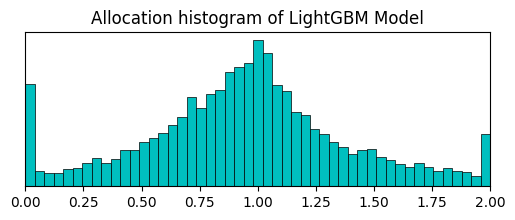

Range of predictions: [0.000000, 2.000000]
multi::0.475


In [199]:
# 単純なLightGBMモデルで試す

allocation_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
)

submit_model = cross_validate(allocation_model, label="LightGBM Model")

### Submission
- time-series streaming形式
- Kaggle サーバーから1batchずつ送られるデータからsubmission.parquetを返す
- 返り値検証があるため，指定された形式で返す
- 指定形式
  - 

In [200]:
def predict(test: pl.DataFrame) -> float:
    """Replace this function with your inference code."""
    test_pd = test.to_pandas()
    # display(test_pd.info())
    if len(test_pd.columns) > 94:
        test_pd = test_pd.drop(
            ["date_id", "is_scored", "lagged_forward_returns", "lagged_risk_free_rate", "lagged_market_forward_excess_returns"], 
            axis = 1)
    
    preds = submit_model.predict(test_pd)
    raw_pred: float = float(preds[0])
    print(f"predict:{raw_pred}")
    
    # --- 出力（float or ndarray）---
    # KaggleのAPI仕様上、float単体かSeries/DataFrameで返す必要あり float(preds[0]) if len(preds) == 1 else preds　
    return convert_ret_to_signal(raw_pred, ret_signal_params)

In [201]:
# サーバー上でpredict(test_batch)を動かす
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))

GatewayRuntimeError: (<GatewayRuntimeErrorType.GATEWAY_RAISED_EXCEPTION: 5>, 'Traceback (most recent call last):\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/core/base_gateway.py", line 134, in run\n    predictions, row_ids = self.get_all_predictions()\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/core/base_gateway.py", line 109, in get_all_predictions\n    for data_batch, row_ids in self.generate_data_batches():\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/default_gateway.py", line 29, in generate_data_batches\n    test = pl.read_csv(self.competition_data_dir / \'test.csv\')\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/io/csv/functions.py", line 549, in read_csv\n    df = _read_csv_impl(\n  File "/usr/local/lib/python3.10/dist-packages/polars/io/csv/functions.py", line 697, in _read_csv_impl\n    pydf = PyDataFrame.read_csv(\nFileNotFoundError: No such file or directory (os error 2): /kaggle/input/hull-tactical-market-prediction/test.csv\n')